# **1- Installing Required Libraries**

In [1]:
%%capture
!pip install --upgrade pip setuptools wheel
!pip install kaggle faiss-cpu texthero
!pip install gensim==4.2.0
!pip install texthero==1.0.5

# **2- Load Data (Kaggle)**

In [ ]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize the API
api = KaggleApi()
api.authenticate()

In [5]:
# Download the dataset
dataset = "patrickgendotti/udacity-course-catalog"
api.dataset_download_files(dataset, path="./data", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/patrickgendotti/udacity-course-catalog


In [6]:
print("Dataset downloaded and extracted to ./data")

Dataset downloaded and extracted to ./data


In [7]:
!ls ./data

all_courses.csv


# **3- Importing Required Libraries**

In [8]:
# Main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Text processing libraries
from nltk.stem import PorterStemmer
import string
import re
import nltk

# Machine learning libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Other libraries
import faiss

# Seaborn settings for beautiful charts
sns.set_context('notebook')
sns.set_style('white')

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Download the necessary data for NLTK (if not already downloaded)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **4- Data preparation**

In [9]:
# Load the dataset
df = pd.read_csv("./data/all_courses.csv")
df.head()

,Title,Type,Description,Level,Duration,Rating,Review Count,Skills Covered,Prerequisites,Affiliates,URL
0,Data Engineering with AWS,nanodegree,"Learn to design data models, build data wareho...",intermediate,4 Months,4.6,1802.0,"AWS Glue, Amazon S3, AWS Data Warehouse, Re...","Intermediate Python, intermediate SQL & comman...",NaN,https://www.udacity.com/course/data-engineer-n...
1,Product Manager,nanodegree,Envision and execute the development of indust...,beginner,4 Months,4.7,864.0,"Product Strategy, Product Design, Product Deve...",No Experience Required,NaN,https://www.udacity.com/course/product-manager...
2,C++,nanodegree,Get hands-on experience building five real-wor...,intermediate,4 Months,4.5,1126.0,"Data Structures & Algorithms, Memory Managemen...",Intermediate Programming,NaN,https://www.udacity.com/course/c-plus-plus-nan...
3,Business Analytics,nanodegree,Gain foundational data skills like analyzing d...,beginner,3 Months,4.8,2649.0,"Excel & Spreadsheets, SQL, Data Visualization,...",NaN,Mode,https://www.udacity.com/course/business-analyt...
4,Data Scientist,nanodegree,"Build effective machine learning models, run d...",advanced,4 Months,4.7,1212.0,"Machine Learning, Deep Learning, Software Engi...","Python, SQL & Statistics","Bertelsmann, Figure Eight, IBM Watson, Insight...",https://www.udacity.com/course/data-scientist-...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           267 non-null    object 
 1   Type            267 non-null    object 
 2   Description     261 non-null    object 
 3   Level           265 non-null    object 
 4   Duration        263 non-null    object 
 5   Rating          62 non-null     float64
 6   Review Count    62 non-null     float64
 7   Skills Covered  267 non-null    object 
 8   Prerequisites   77 non-null     object 
 9   Affiliates      138 non-null    object 
 10  URL             267 non-null    object 
dtypes: float64(2), object(9)
memory usage: 23.1+ KB


In [11]:
# select columns the we are interested
df1 = df[['Title', 'Description']]
df1.head()

,Title,Description
0,Data Engineering with AWS,"Learn to design data models, build data wareho..."
1,Product Manager,Envision and execute the development of indust...
2,C++,Get hands-on experience building five real-wor...
3,Business Analytics,Gain foundational data skills like analyzing d...
4,Data Scientist,"Build effective machine learning models, run d..."


In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        267 non-null    object
 1   Description  261 non-null    object
dtypes: object(2)
memory usage: 4.3+ KB


In [13]:
df1 = df1.dropna()

# **5- Preprocessing Text for Clustering**

In [14]:
# selecting the column that has text
text = df1['Description']

# removing null values
text = text[~pd.isnull(text)] #removing missing values

# preprocessing
text=text.tolist()
text[:3]

['Learn to design data models, build data warehouses and data lakes, automate data pipelines, and manage massive datasets.',
 'Envision and execute the development of industry-defining products, and learn how to successfully bring them to market.',
 'Get hands-on experience building five real-world projects in this popular general-purpose programming language.']

In [15]:
# make it lower case
text = [t.lower() for t in text]
text[:3]

# Strip all punctuation from each article
# This uses str.translate to map all punctuation to the empty string
table = str.maketrans('', '', string.punctuation)
text = [t.translate(table) for t in text]

# Convert all numbers in the article to the word 'num' using regular expressions
text = [re.sub(r'\d+', 'num', t) for t in text]
# Print the first article as a running example
text[:2]

['learn to design data models build data warehouses and data lakes automate data pipelines and manage massive datasets',
 'envision and execute the development of industrydefining products and learn how to successfully bring them to market']

In [16]:
# creating stemmer model and fit evey sentence to it
stemmer = PorterStemmer()
text_stem = [stemmer.stem(t) for t in text]

In [17]:
# for lemmatization, you need to download "wordnet" repository which contains family of words
nltk.download("wordnet")

# create lemmatizer and apply it for every sentence in the text
lem = nltk.stem.wordnet.WordNetLemmatizer()
text_lem = [lem.lemmatize(t) for t in text_stem]
text_lem[:3]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['learn to design data models build data warehouses and data lakes automate data pipelines and manage massive dataset',
 'envision and execute the development of industrydefining products and learn how to successfully bring them to market',
 'get handson experience building five realworld projects in this popular generalpurpose programming languag']

# **6- Vectorizing the Sentences**

In [18]:
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
model_SBERT = SentenceTransformer('all-MiniLM-L6-v2')

In [19]:
embeddings = model_SBERT.encode(text_lem, convert_to_numpy=True,show_progress_bar=True,batch_size=100) # By default, convert_to_numpy = True
embeddings.shape

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

(261, 384)

In [20]:
print(embeddings[0][:50])

[-0.01480989  0.00781282  0.00781513  0.01387694 -0.05618196 -0.11001204
 -0.06155609  0.0179883  -0.07303286  0.04144767  0.00735863 -0.09865781
  0.04786148 -0.02755714 -0.047103    0.07123245  0.00475435 -0.04003643
 -0.04615238 -0.09243393 -0.05173739  0.02388019 -0.04090619 -0.0089699
 -0.01613367  0.06516808  0.07876749 -0.0505801  -0.01091037 -0.02748189
 -0.08316791 -0.05537613  0.00366347  0.07751952  0.00803749  0.0238474
 -0.01209079  0.03625084  0.01020971 -0.01871606  0.04401565 -0.0367318
 -0.03628971 -0.04790556  0.02025005 -0.04055879 -0.05155111 -0.05851816
  0.02327655  0.06464304]


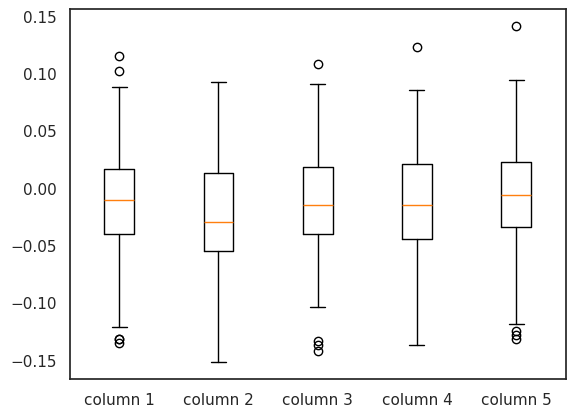

In [21]:
fig, ax = plt.subplots()

# Create the box plots
bp1 = ax.boxplot(embeddings[:,0], positions=[1], widths=0.3)
bp2 = ax.boxplot(embeddings[:,1], positions=[2], widths=0.3)
bp3 = ax.boxplot(embeddings[:,2], positions=[3], widths=0.3)
bp4 = ax.boxplot(embeddings[:,3], positions=[4], widths=0.3)
bp4 = ax.boxplot(embeddings[:,4], positions=[5], widths=0.3)

# Set the x-axis labels
ax.set_xticklabels(['column 1', 'column 2', 'column 3','column 4','column 5'])

# Show the plot
plt.show()

# **7-Choosing the Number of Clusters (k) for K-means Clustering**

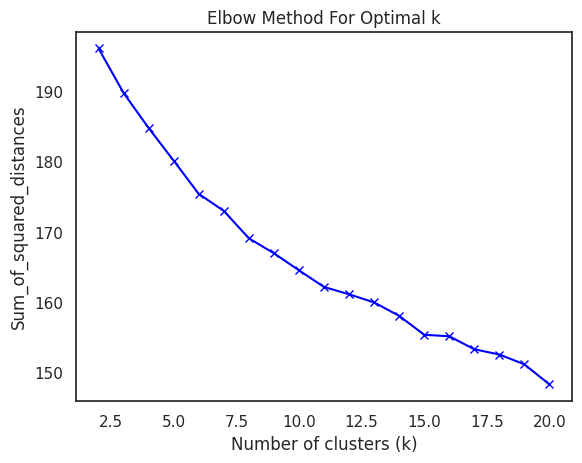

In [22]:
Sum_of_squared_distances = []

# range of possible k from 2 to 20
K = range(2,21)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(embeddings)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

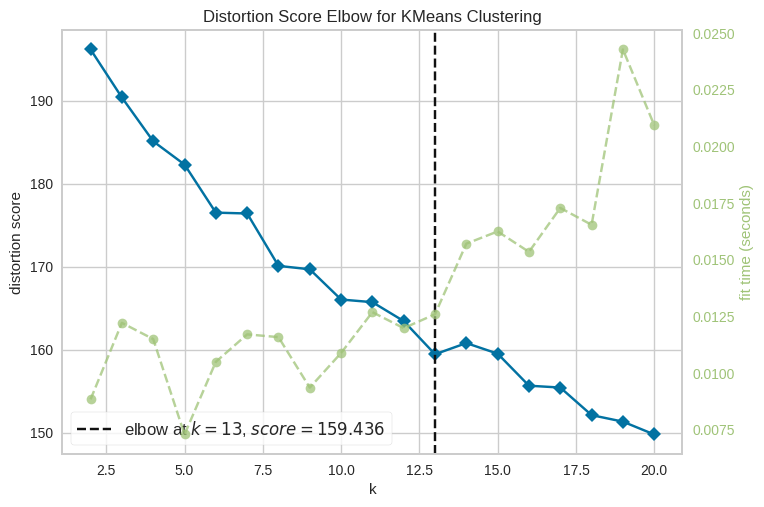

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21), timings= True)
visualizer.fit(embeddings)
visualizer.show()

In [24]:
optimal_Ks=[]

==> Silhouetter Score: 0.045


SilhouetteVisualizer(ax=<Axes: >, colors='yellowbrick',
                     estimator=KMeans(n_clusters=2, random_state=11))

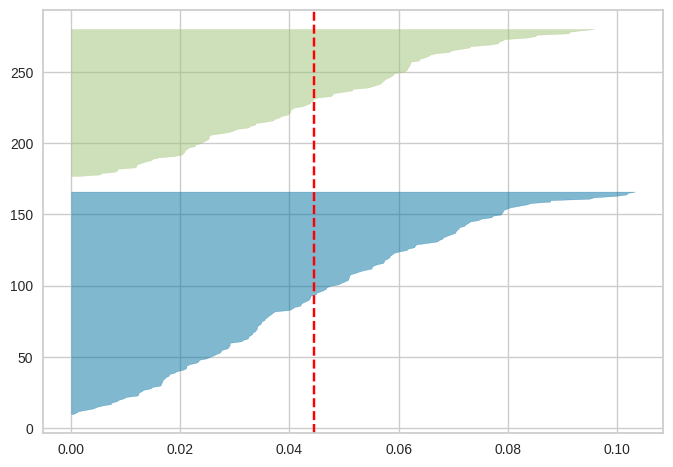

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the KMeans models
km = KMeans(n_clusters=2, random_state=11)

# Fit the KMeans model
km.fit_predict(embeddings)

# Calculate Silhoutte Score
score = silhouette_score(embeddings, km.labels_, metric='euclidean')

# Print the score
print('==> Silhouetter Score: %.3f' % score)
SilhouetteVisualizer(km, colors='yellowbrick').fit(embeddings)

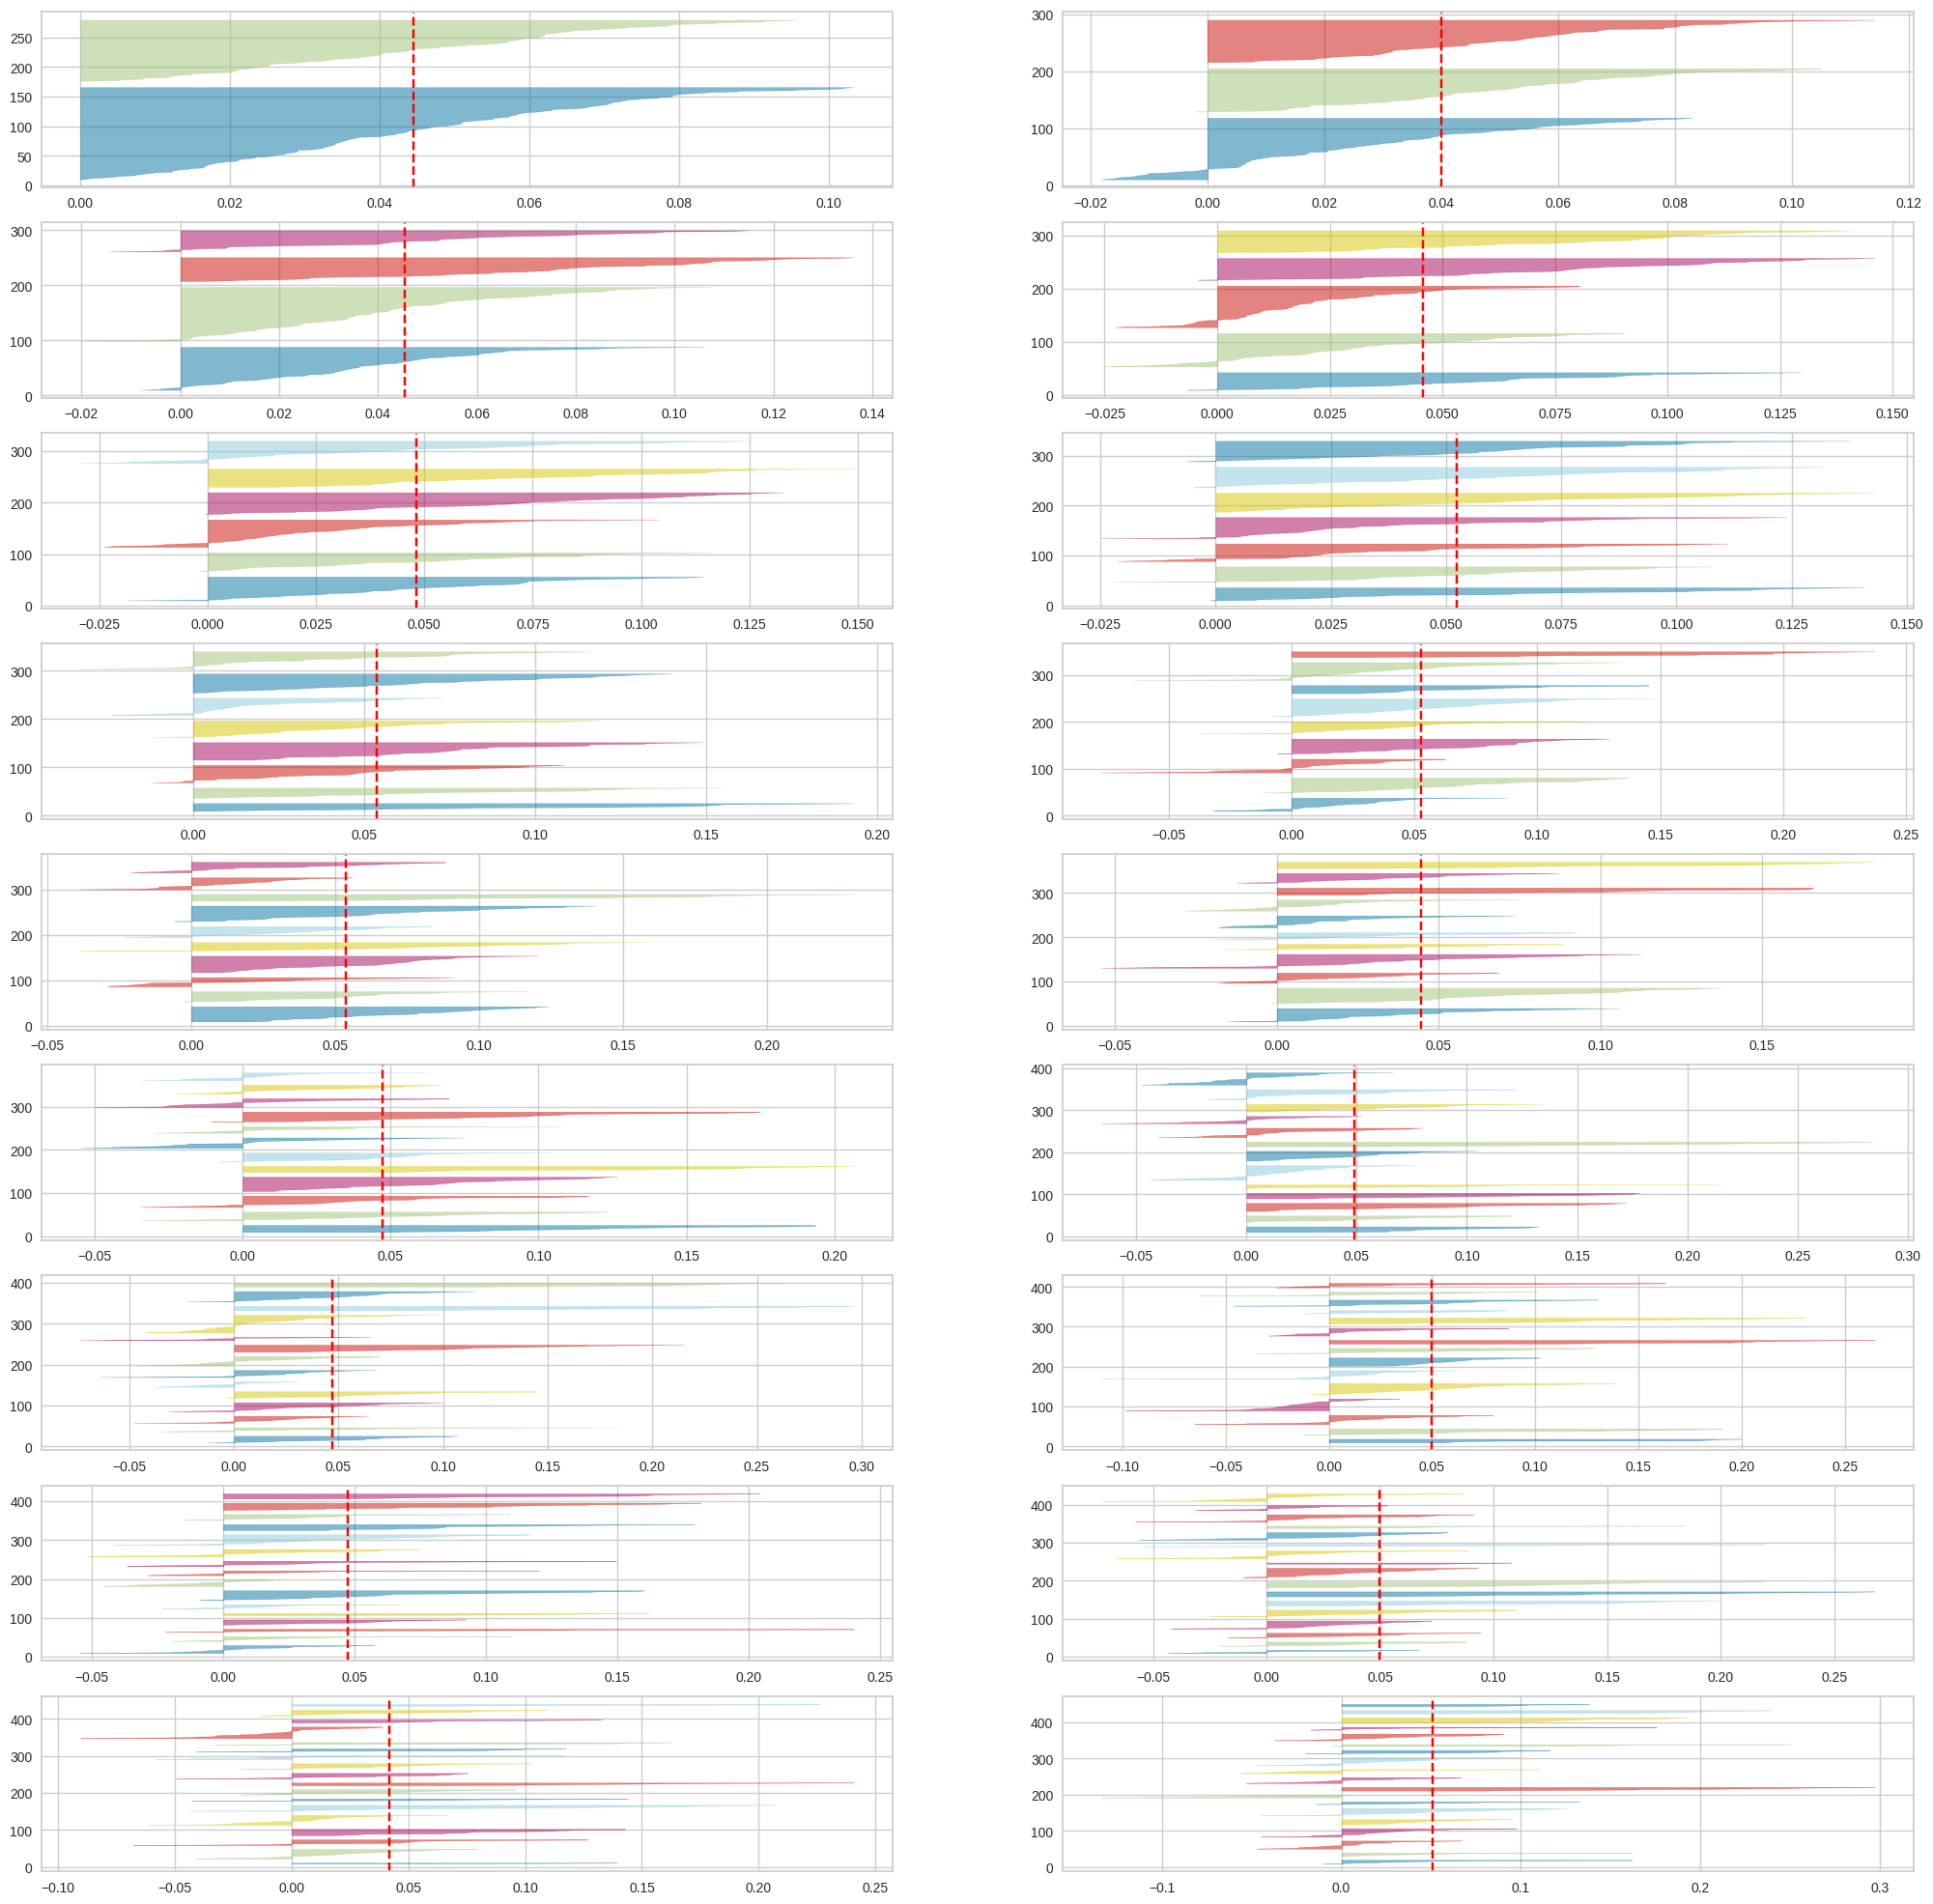

In [26]:
# Create a figure and set of subplots with 10 rows and 2 columns.
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(25, 25))

# Iterate through the range of number of clusters (2 to 20)
for i in range(2, 20):
    # Create a KMeans instance with the number of clusters as i
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=11)
    # Divide i by 2 and get the quotient and remainder
    quo, rem = divmod(i, 2)

    # Create an instance of SilhouetteVisualizer with the KMeans instance and set the color to yellowbrick
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[quo-1][rem])
    # Fit the visualizer with the embeddings
    visualizer.fit(embeddings)

In [27]:
from sklearn.metrics import silhouette_score

# Create a list of possible numbers of clusters to try
num_clusters = list(range(2, 20))

# Calculate the silhouette scores for each number of clusters
silhouette_scores = []
for k in num_clusters:
    # run clustering for each k
    kmeans = KMeans(n_clusters=k,n_init=10)
    kmeans.fit(embeddings)
    labels = kmeans.predict(embeddings)
    #calculating the sihouetter score
    sil_score=silhouette_score(embeddings,labels)
    print("cluster:",k,  "score -> ",  sil_score)
    silhouette_scores.append(sil_score)


# displaying the optimum number of clusters
optimal_num_clusters = num_clusters[silhouette_scores.index(max(silhouette_scores))]
print("The highest s-score of the k-clusters: " , optimal_num_clusters)

#appending the result into the opmimum list
optimal_Ks.append(optimal_num_clusters)

cluster: 2 score ->  0.044514555
cluster: 3 score ->  0.04160906
cluster: 4 score ->  0.04029374
cluster: 5 score ->  0.046562713
cluster: 6 score ->  0.048248958
cluster: 7 score ->  0.05235561
cluster: 8 score ->  0.056942843
cluster: 9 score ->  0.052849736
cluster: 10 score ->  0.047229197
cluster: 11 score ->  0.048432115
cluster: 12 score ->  0.049334947
cluster: 13 score ->  0.049984466
cluster: 14 score ->  0.051017605
cluster: 15 score ->  0.046954084
cluster: 16 score ->  0.049180992
cluster: 17 score ->  0.04975503
cluster: 18 score ->  0.043717694
cluster: 19 score ->  0.042640075
The highest s-score of the k-clusters:  8


In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Create a list of possible numbers of clusters to try
num_clusters = list(range(2, 21))

# Calculate the silhouette scores for each number of clusters
dav_scores = []
for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embeddings)
    labels = kmeans.predict(embeddings)

    # calculating Davies score for each k
    dav_score=davies_bouldin_score(embeddings, labels)
    print("cluster:",k,  "value -> ",  dav_score)
    dav_scores.append(dav_score)


# displaying the optimum number of clusters
optimal_num_clusters = num_clusters[dav_scores.index(min(dav_scores))]
print("The optimum score of the k-clusters: " , optimal_num_clusters)

#appending the result into the opmimum list
optimal_Ks.append(optimal_num_clusters)

cluster: 2 value ->  4.6619061899382395
cluster: 3 value ->  4.1602853193236635
cluster: 4 value ->  3.8129431489809757
cluster: 5 value ->  4.14260324340338
cluster: 6 value ->  3.618347580959306
cluster: 7 value ->  3.5587116485585595
cluster: 8 value ->  3.58901460971167
cluster: 9 value ->  3.2446519013506387
cluster: 10 value ->  3.380370102418523
cluster: 11 value ->  3.2327717612878772
cluster: 12 value ->  2.98451756570042
cluster: 13 value ->  3.2018111970224306
cluster: 14 value ->  3.091138821852429
cluster: 15 value ->  2.9963756437518168
cluster: 16 value ->  3.124346345765332
cluster: 17 value ->  2.97351596569768
cluster: 18 value ->  2.896585661857604
cluster: 19 value ->  2.835191509123994
cluster: 20 value ->  3.0513589515579405
The optimum score of the k-clusters:  19


In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

# Create a list of possible numbers of clusters to try
num_clusters = list(range(2, 21))

# Calculate the silhouette scores for each number of clusters
cal_scores = []
for k in num_clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embeddings)
    labels = kmeans.predict(embeddings)

    # calculating Calinski index
    cal_score=calinski_harabasz_score(embeddings, labels)
    print("cluster:",k,  "value -> ",  cal_score)
    cal_scores.append(cal_score)


# displaying the optimum number of clusters
optimal_num_clusters = num_clusters[cal_scores.index(max(cal_scores))]
print("The optimum score of the k-clusters: " , optimal_num_clusters)

cluster: 2 value ->  12.152550328114865
cluster: 3 value ->  9.665572388685344
cluster: 4 value ->  9.060799283337275
cluster: 5 value ->  8.665211545880185
cluster: 6 value ->  8.301423603157225
cluster: 7 value ->  7.2028261689456885
cluster: 8 value ->  7.478230172803185
cluster: 9 value ->  7.04213818215384
cluster: 10 value ->  6.432112482139088
cluster: 11 value ->  6.364779709170546
cluster: 12 value ->  5.892169431145187
cluster: 13 value ->  5.662902512054627
cluster: 14 value ->  5.409000084915235
cluster: 15 value ->  5.394808216093761
cluster: 16 value ->  5.02442033189084
cluster: 17 value ->  4.97499918031272
cluster: 18 value ->  5.019698044558069
cluster: 19 value ->  4.6442400896544465
cluster: 20 value ->  4.570959140218047
The optimum score of the k-clusters:  2


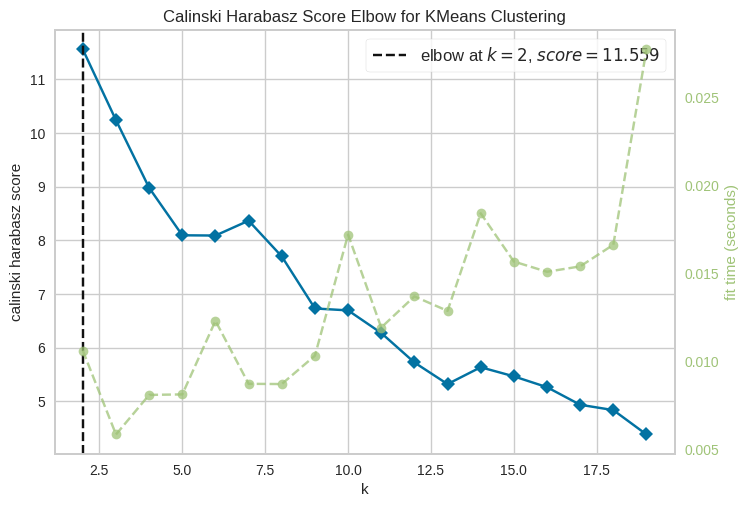

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [30]:
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20),metric='calinski_harabasz')
visualizer.fit(embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# **8-Clustering the Data**

In [31]:
# lets use median of the optimal number of clusters
true_k = int(np.median(optimal_Ks))
k_model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
k_model.fit(embeddings)

# the labels given by clusters
labels=k_model.labels_
labels

array([10,  5, 12,  5,  3,  3,  5,  6,  2,  6, 11,  3, 10,  3,  2, 11,  2,
       11,  9, 10,  6,  5,  5,  5, 11,  8,  2,  2,  6, 12,  2,  9,  9,  5,
        5,  6, 12,  8,  0,  7, 10, 10,  3, 12,  2,  9,  5,  3, 10,  2,  2,
        1, 12,  2,  5, 10,  5,  5, 10, 12,  5,  7,  3,  5,  7, 12, 10,  7,
        4, 10,  9,  7,  5,  7,  7,  2,  6,  7,  7,  2,  2,  3,  2,  6,  2,
        6,  2,  2,  2,  6,  5,  2,  6, 10, 10,  8,  6,  2,  3,  8,  3,  2,
        2,  2,  3,  2,  2,  6, 10, 12, 11, 11,  4, 11,  4,  9,  4,  4, 12,
        4,  0,  1,  0,  8, 11, 12,  0,  1, 12, 11,  4,  8,  9, 11,  1,  0,
        9,  4, 12,  6,  0,  9, 12,  1,  8, 10, 12, 12, 11,  7,  4,  6, 11,
        8,  0,  5,  9, 11,  9,  0, 12,  9,  1,  4,  1,  6,  0,  6,  8,  1,
       12,  0, 12, 12,  9,  8,  1,  6,  6,  6,  6,  1,  4,  6, 10,  1,  4,
        8,  6,  6,  9,  4,  0,  6,  8,  8,  0, 12,  6,  0,  9, 12,  4, 12,
        4,  4,  0,  7,  9,  8, 11,  7, 10,  4,  8,  4,  1,  8,  4,  6,  6,
        6, 10,  8,  8, 10

In [32]:
# lets vote the median of the suggested clusters
int(np.median(optimal_Ks))

13

In [33]:
df1.shape

(261, 2)

In [34]:
# adding the labels to the our original dataset
df1['labels'] = pd.Categorical(labels)

df1.head()

,Title,Description,labels
0,Data Engineering with AWS,"Learn to design data models, build data wareho...",10
1,Product Manager,Envision and execute the development of indust...,5
2,C++,Get hands-on experience building five real-wor...,12
3,Business Analytics,Gain foundational data skills like analyzing d...,5
4,Data Scientist,"Build effective machine learning models, run d...",3


In [35]:
embeddings.shape

(261, 384)

# **9-Plotting the Results**

In [36]:
#reduce the dimension of data into two and then plot it
from sklearn.manifold import TSNE
X_embedded_2d = TSNE(n_components=2).fit_transform(embeddings)

In [37]:
df1

,Title,Description,labels
0,Data Engineering with AWS,"Learn to design data models, build data wareho...",10
1,Product Manager,Envision and execute the development of indust...,5
2,C++,Get hands-on experience building five real-wor...,12
3,Business Analytics,Gain foundational data skills like analyzing d...,5
4,Data Scientist,"Build effective machine learning models, run d...",3
...,...,...,...
262,Front-End Interview Prep,Answer front-end technical and behavioral inte...,7
263,Full-Stack Interview Prep,Answer common full stack and web security inte...,7
264,Data Structures & Algorithms in Swift,Review and practice the skills technical inter...,1
265,iOS Interview Prep,Answer iOS and mobile development interview qu...,1


In [38]:
import texthero as hero

In [39]:
df1

,Title,Description,labels
0,Data Engineering with AWS,"Learn to design data models, build data wareho...",10
1,Product Manager,Envision and execute the development of indust...,5
2,C++,Get hands-on experience building five real-wor...,12
3,Business Analytics,Gain foundational data skills like analyzing d...,5
4,Data Scientist,"Build effective machine learning models, run d...",3
...,...,...,...
262,Front-End Interview Prep,Answer front-end technical and behavioral inte...,7
263,Full-Stack Interview Prep,Answer common full stack and web security inte...,7
264,Data Structures & Algorithms in Swift,Review and practice the skills technical inter...,1
265,iOS Interview Prep,Answer iOS and mobile development interview qu...,1


In [40]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px

# Assuming df1 and embeddings are already defined
df2 = df1.copy()
df2['vectors'] = np.array(embeddings).tolist()

# Using TSNE method to reduce the dimensions
tsne_model = TSNE(n_components=2, random_state=42)
tsne_results = tsne_model.fit_transform(np.array(df2['vectors'].tolist()))

# Adding the results to the DataFrame
df2['tsne-2d-one'] = tsne_results[:, 0]
df2['tsne-2d-two'] = tsne_results[:, 1]

# Plot the data using plotly
fig = px.scatter(
    df2, x='tsne-2d-one', y='tsne-2d-two',
    color='labels', hover_data=['Title'],
    title="Course categories"
)

fig.show()

In [43]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px

# Example embeddings and DataFrame
embeddings = np.random.rand(100, 50)  # Example embeddings, replace with actual embeddings
df1 = pd.DataFrame({
    'Title': [f'Title {i}' for i in range(100)],
    'labels': np.random.choice(['Category 1', 'Category 2', 'Category 3'], 100)
})

# Copy the DataFrame and add the embeddings
df2 = df1.copy()
df2['vectors'] = embeddings.tolist()

# Using TSNE to reduce dimensions to 3 for 3D plotting
tsne_model = TSNE(n_components=3, random_state=42)
X_embedded_3d = tsne_model.fit_transform(embeddings)

# Adding the results to the DataFrame
df2['tsne-3d-one'] = X_embedded_3d[:, 0]
df2['tsne-3d-two'] = X_embedded_3d[:, 1]
df2['tsne-3d-three'] = X_embedded_3d[:, 2]

# Plotting the data using plotly
fig = px.scatter_3d(
    df2, x='tsne-3d-one', y='tsne-3d-two', z='tsne-3d-three',
    color='labels', hover_data=['Title'],
    title="3D t-SNE Plot of Course Categories"
)

fig.show()